In [1]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

'/home/nils/projects/uq-method-box'

In [2]:
from uq_method_box.datamodules import ToyHeteroscedasticDatamodule
from uq_method_box.models import MLP
from uq_method_box.uq_methods import (
    BaseModel,
    CQR,
    MCDropoutModel,
    QuantileRegressionModel,
    LaplaceModel,
    DeepEnsembleModel,
)

import matplotlib.pyplot as plt
import torch
import numpy as np

from uq_method_box.viz_utils import (
    plot_toy_data,
    plot_predictions,
    plot_calibration_uq_toolbox,
)

from uq_method_box.train_utils import basic_train_loop, NLL, QuantileLoss

from uq_method_box.eval_utils import compute_empirical_coverage

%load_ext autoreload
%autoreload 2

In [3]:
plt.rcParams["figure.figsize"] = [28, 9]

In [4]:
dm = ToyHeteroscedasticDatamodule()
X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

X_test_cpu = torch.clone(X_test).numpy()
y_test_cpu = torch.clone(y_test).numpy()

# Base Model

In [5]:
base_config = {
    "model": {
        "model_name": "mlp",
    },
    "optimizer": {"lr": 1e-2},
}
base_model = BaseModel(base_config, MLP())

/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [6]:
base_model = basic_train_loop(
    base_model,
    torch.nn.MSELoss(),
    train_loader,
    base_config["optimizer"]["lr"],
    n_epochs=1000,
)

100%|██████████| 1000/1000 [00:06<00:00, 158.40it/s, loss=0.024386035278439522]


In [7]:
# get predictions
with torch.no_grad():
    y_preds_det = base_model(X_test)

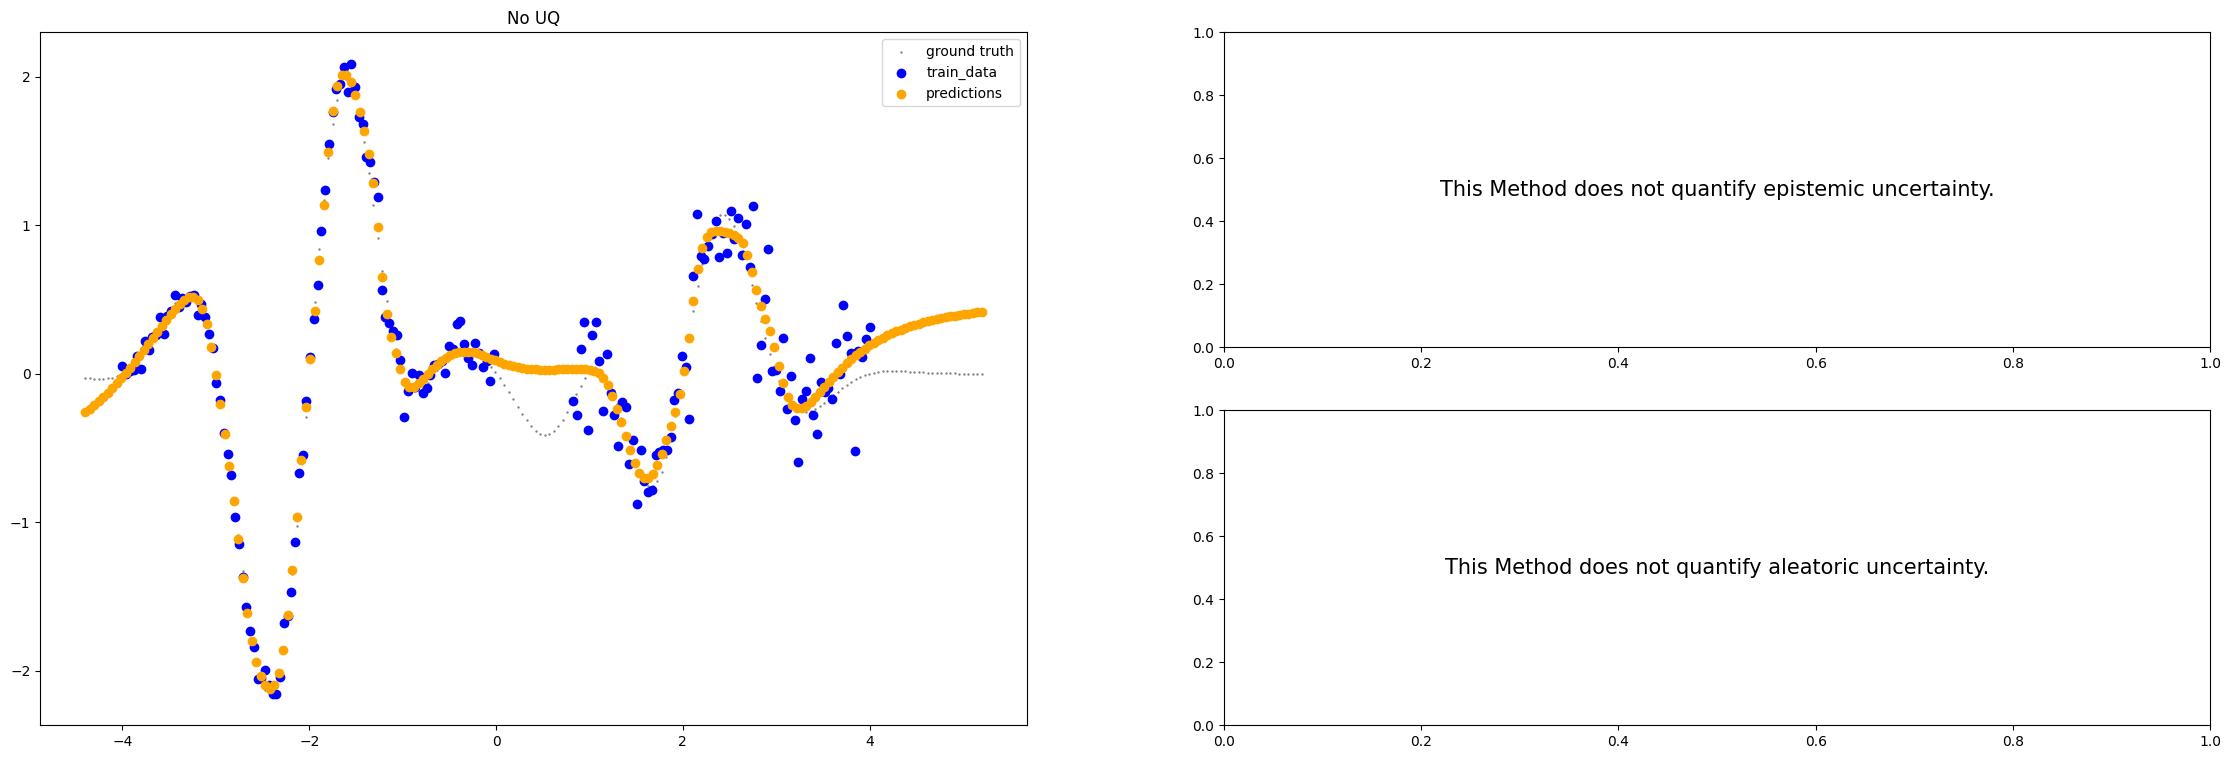

In [8]:
# plot predictions
plot_predictions(X_train, y_train, X_test_cpu, y_test_cpu, y_preds_det, title="No UQ")

# MC Dropout

In [9]:
mc_config = {
    "model": {"model_name": "mlp", "mc_samples": 20},
    "optimizer": {"lr": 1e-2},
}
mc_droput_model = MCDropoutModel(
    mc_config,
    MLP(n_outputs=2, dropout_p=0.1, n_hidden=[50, 50, 50], predict_sigma=True),
)

# train_model
basic_train_loop(mc_droput_model, NLL(), train_loader, lr=1e-2, n_epochs=1000)

# get predictions
with torch.no_grad():
    out = mc_droput_model.predict_step(X_test)
    mc_mean_nll = out["mean"]
    mc_std_nll = out["pred_uct"]
    mc_epistemic = out["epistemic_uct"]
    mc_aleatoric = out["aleatoric_uct"]

100%|██████████| 1000/1000 [00:19<00:00, 51.31it/s, loss=-2.1297075748443604]


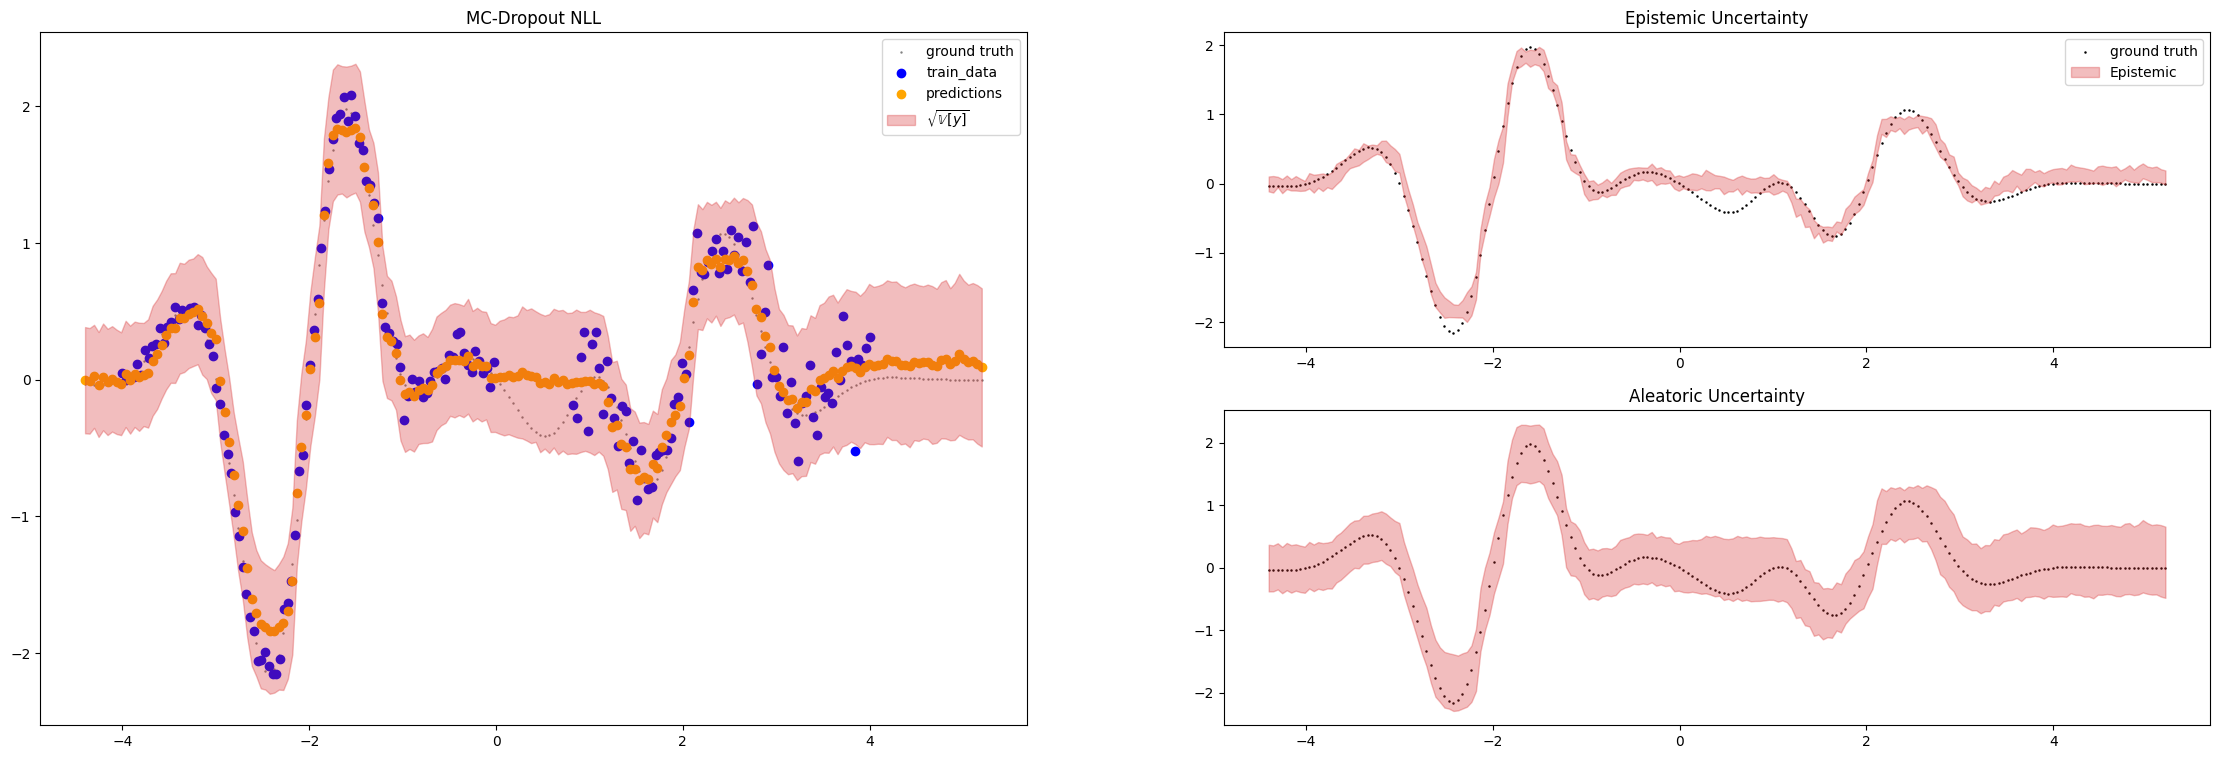

<Figure size 2800x900 with 0 Axes>

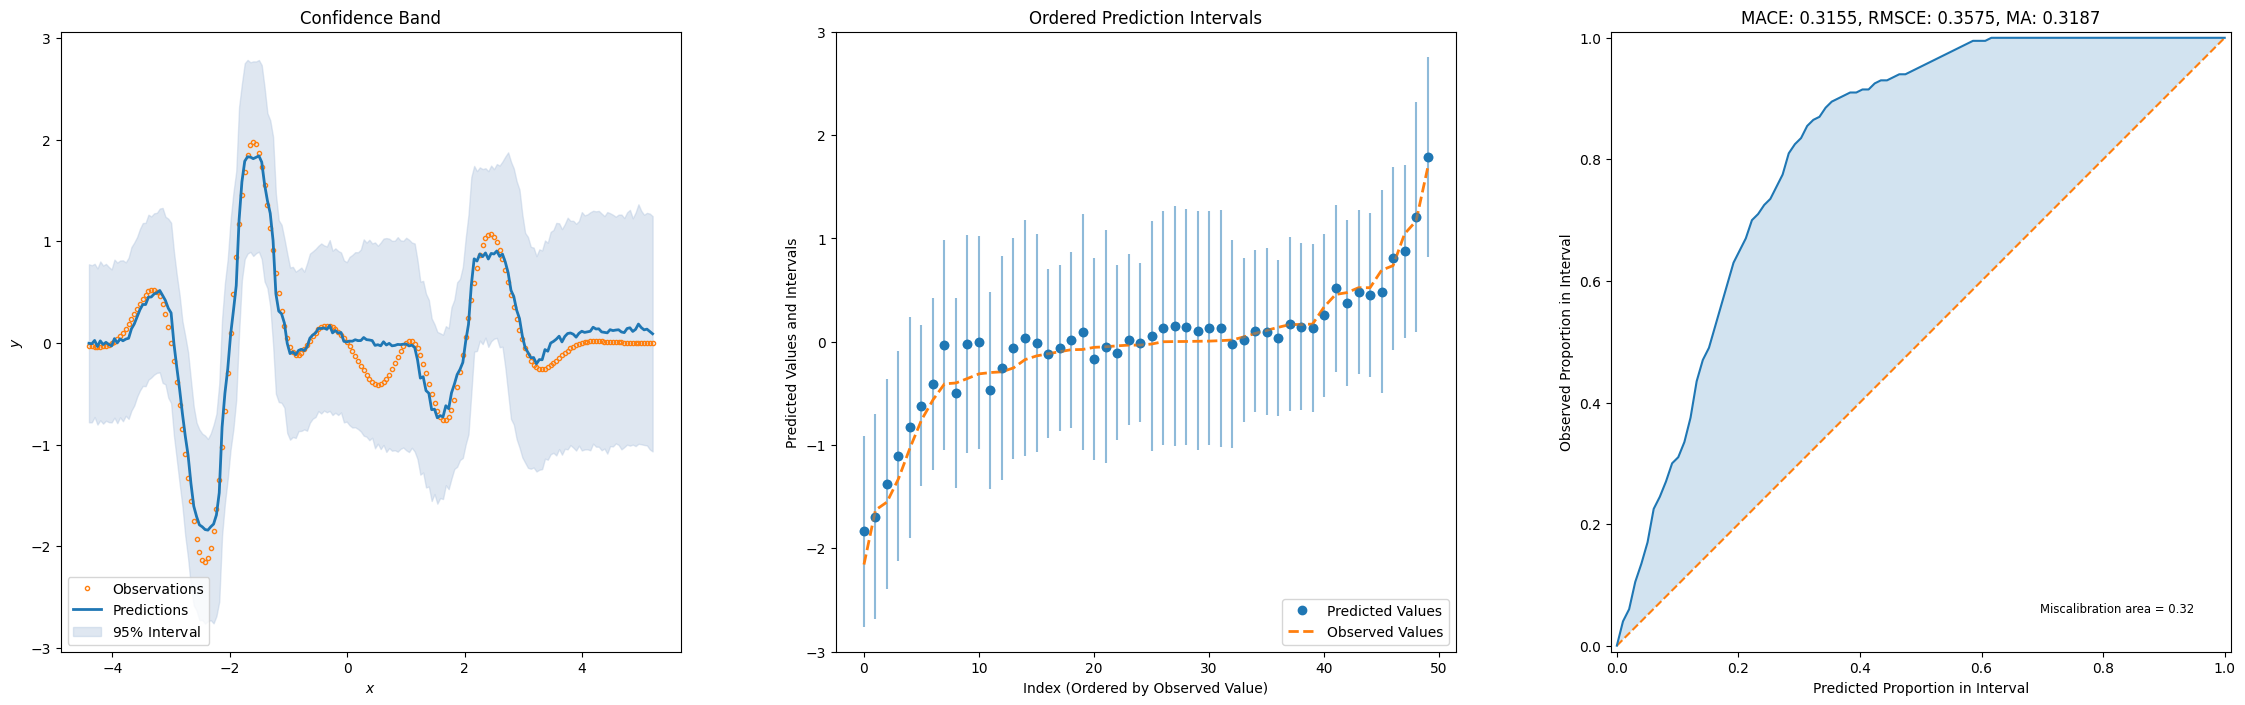

In [10]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    mc_mean_nll,
    mc_std_nll,
    epistemic=mc_epistemic,
    aleatoric=mc_aleatoric,
    title="MC-Dropout NLL",
)
plot_calibration_uq_toolbox(mc_mean_nll, mc_std_nll, y_test_cpu, X_test_cpu)

# Quantile Regression

In [11]:
quantiles = [0.1, 0.5, 0.9]
qr_config = {
    "model": {"model_name": "mlp", "quantiles": quantiles},
    "optimizer": {"lr": 1e-2},
}

In [12]:
qr_model = QuantileRegressionModel(
    qr_config, MLP(n_outputs=len(quantiles), n_hidden=[50, 50, 50])
)

# train_model
basic_train_loop(qr_model, qr_model.criterion, train_loader, lr=1e-2, n_epochs=1000)

# get predictions
with torch.no_grad():
    out = qr_model.predict_step(X_test)
    qr_mean = out["mean"]
    qr_median = out["median"]
    qr_std = out["pred_uct"]
    qr_aleatoric = out["aleatoric_uct"]
    quantile_preds = np.stack(
        [out["lower_quant"], qr_mean, out["upper_quant"]], axis=-1
    )

100%|██████████| 1000/1000 [00:13<00:00, 76.05it/s, loss=0.03247812017798424] 


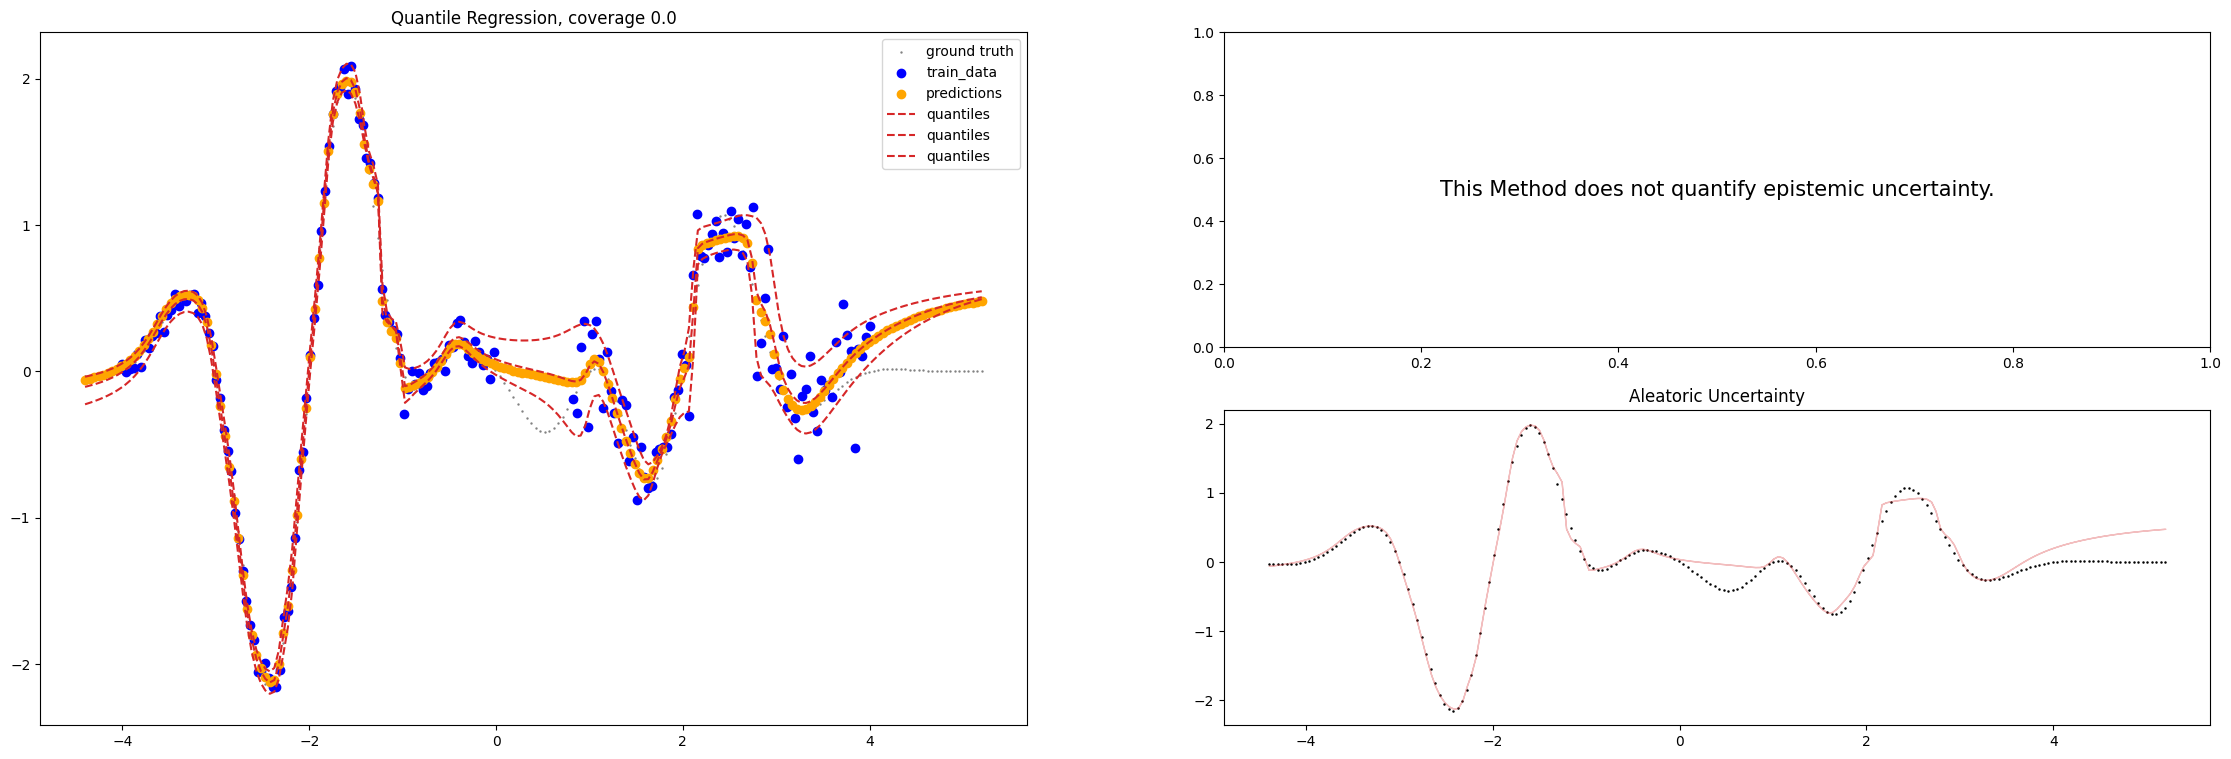

<Figure size 2800x900 with 0 Axes>

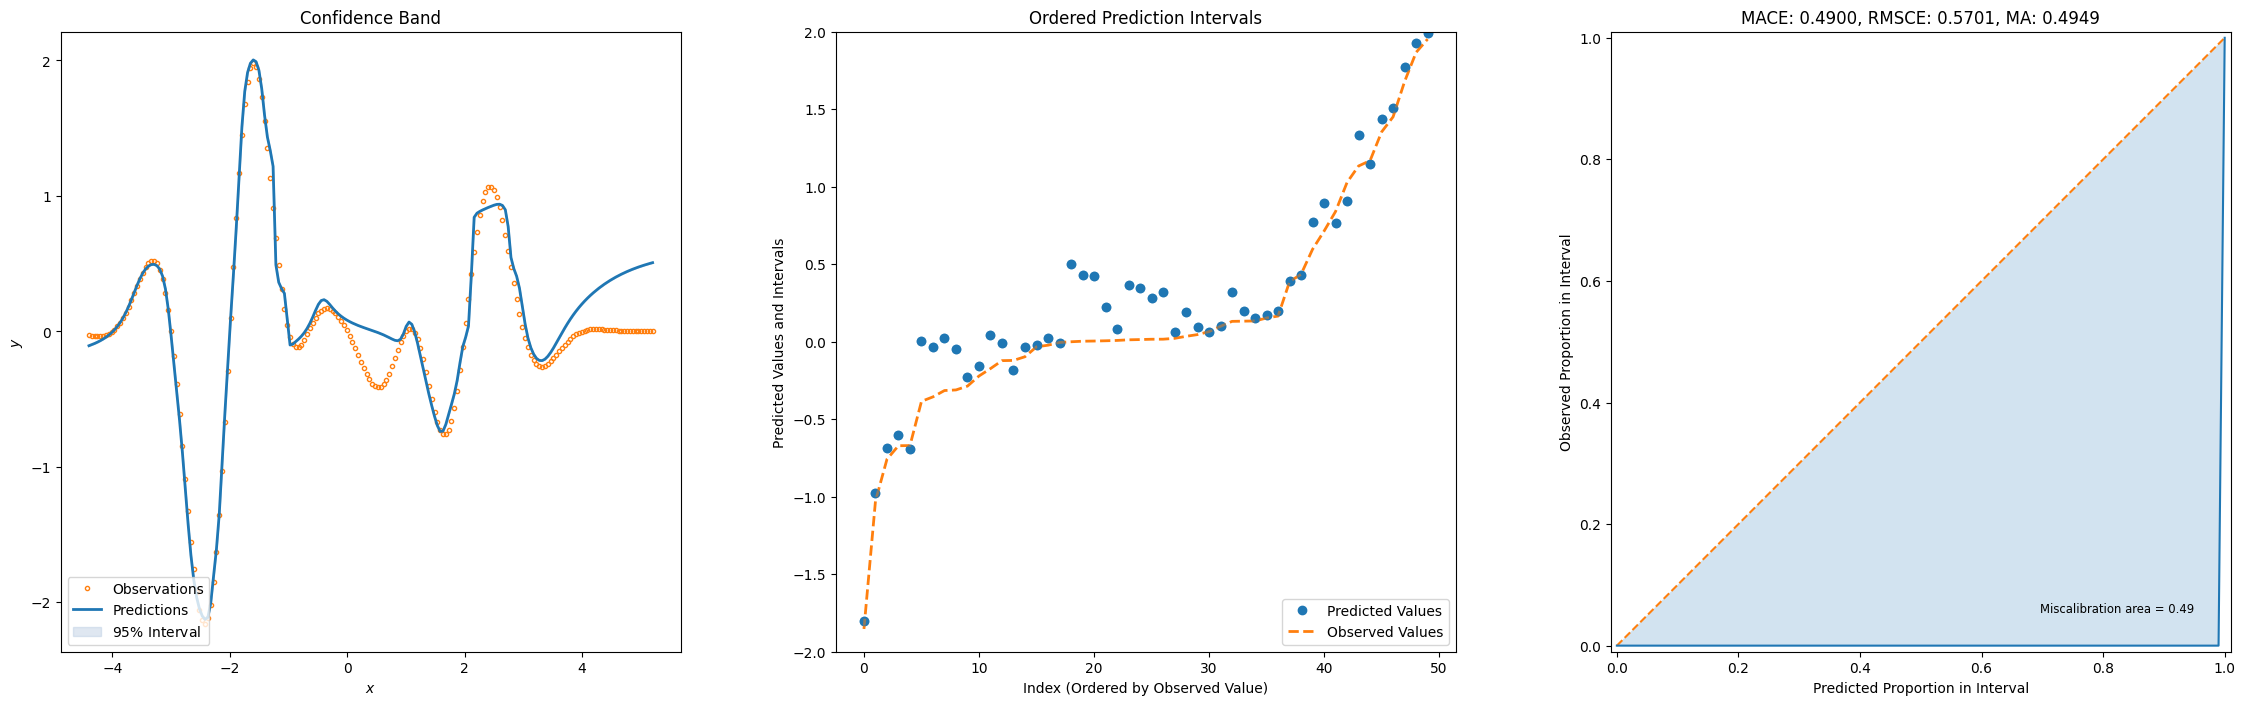

In [13]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    qr_median,
    pred_quantiles=quantile_preds,
    aleatoric=qr_aleatoric,
    title=f"Quantile Regression, coverage {compute_empirical_coverage(quantile_preds, y_test_cpu)}",
)
plot_calibration_uq_toolbox(qr_mean, qr_std, y_test_cpu, X_test_cpu)

# conformalized Quantile Regression

In [14]:
# wrapper around Quantile Regression Model
cqr = CQR(qr_config, qr_model, quantiles, test_loader)

# get predictions
with torch.no_grad():
    out = cqr.predict_step(X_test)
    cqr_mean = out["mean"]
    cqr_std = out["pred_uct"]
    cqr_aleatoric = out["aleatoric_uct"]
    cqr_quantile_preds = np.stack(
        [out["lower_quant"], cqr_mean, out["upper_quant"]], axis=-1
    )

0.5323142765901139


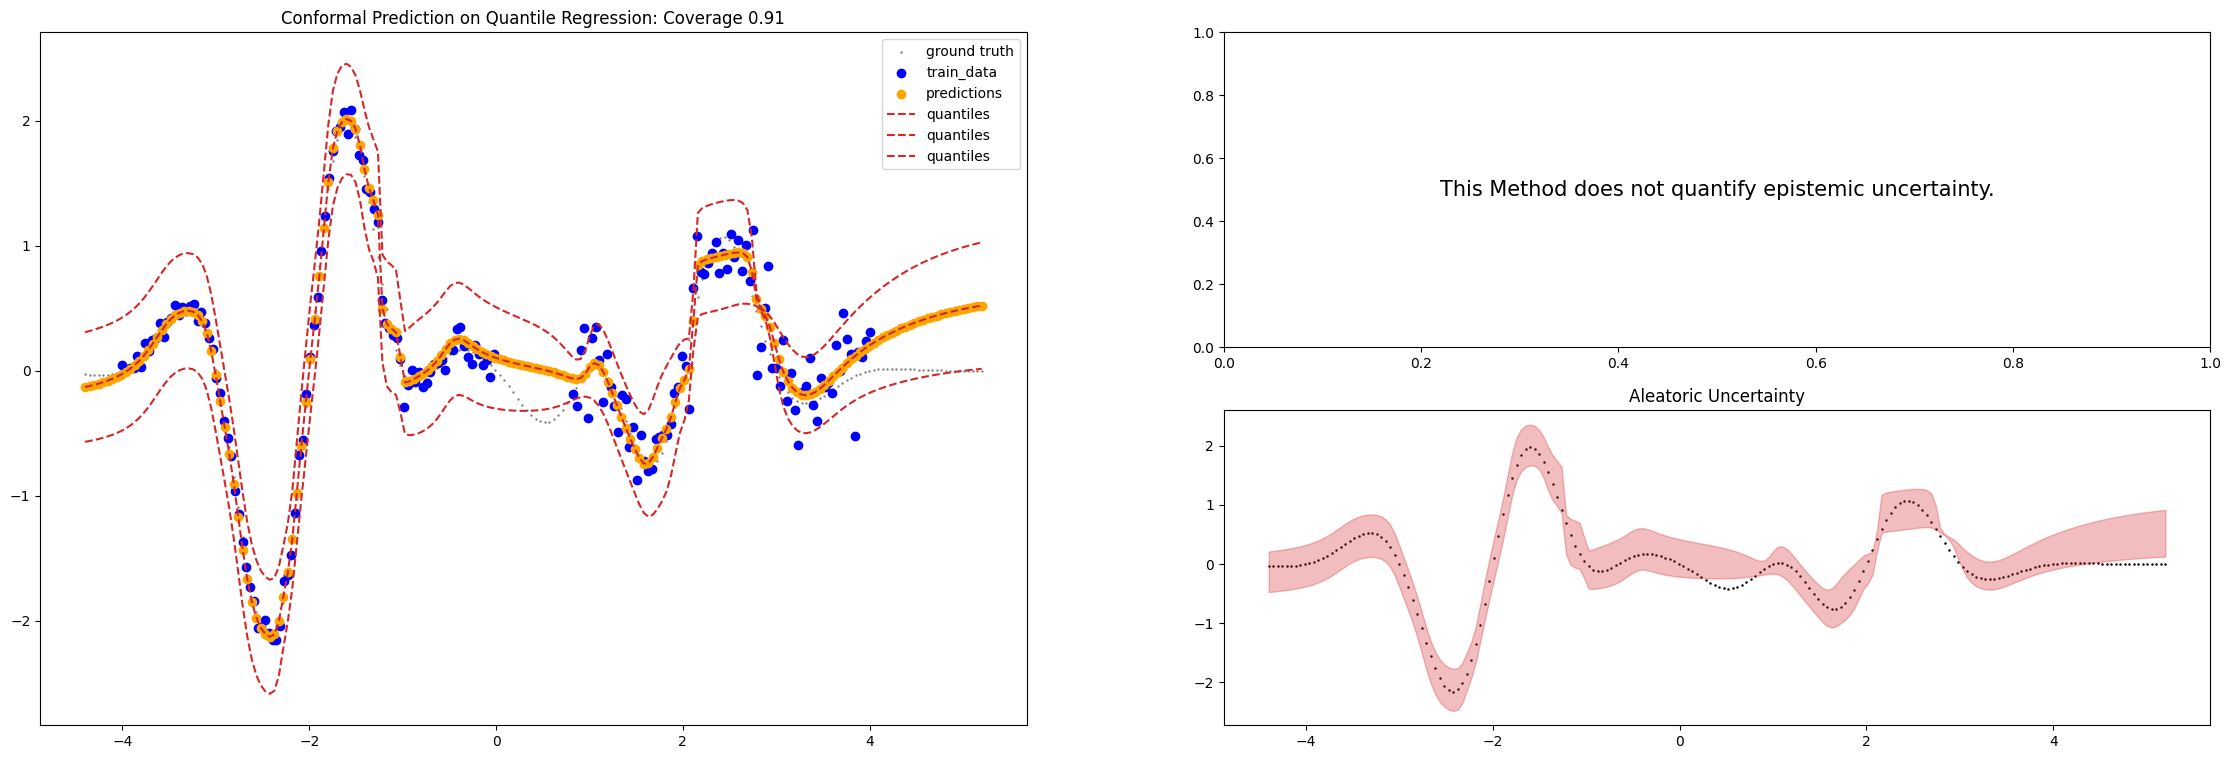

<Figure size 2800x900 with 0 Axes>

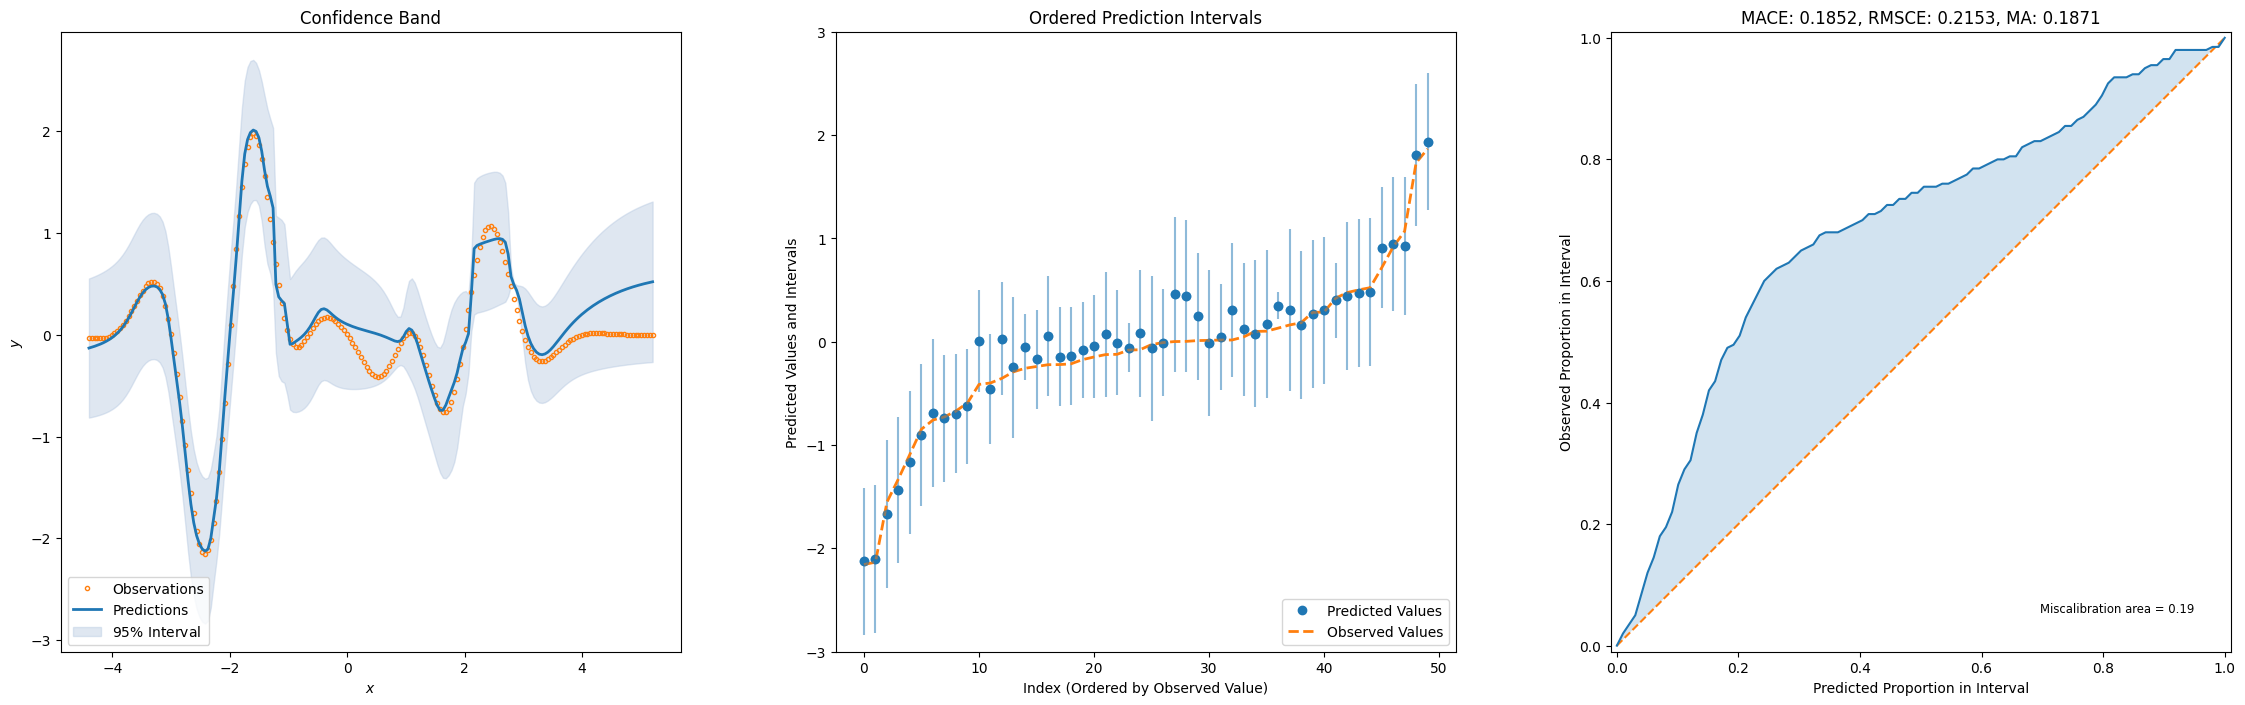

In [15]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    cqr_mean,
    pred_quantiles=cqr_quantile_preds,
    aleatoric=cqr_aleatoric,
    title=f"Conformal Prediction on Quantile Regression: Coverage {compute_empirical_coverage(cqr_quantile_preds, y_test_cpu)}",
)
plot_calibration_uq_toolbox(cqr_mean, cqr_std, y_test_cpu, X_test_cpu)

# Laplace Approximation

TODO: need to fix this implementation

In [16]:
# laplace_config = {
#     "model": {
#         "model_name": "laplace_mlp",
#         "laplace": {
#             "prior_mean": 0,
#             "prior_precision": 1,
#             "subset_of_weights": "all",
#             "hessian_structure": "full",
#             "tune_precision_lr": 0.1,
#             "n_epochs_tune_precision": 2
#         }
#     },
#     "optimizer": {"lr": 1e-2},
# }
# laplace = LaplaceModel(laplace_config, train_loader, model=base_model.model)


# la_out = laplace.predict_step(X_test)
# la_mean = la_out["mean"]
# la_predictive = la_out["pred_uct"]
# la_epistemic = la_out["epistemic_uct"]
# la_aleatoric = la_out["aleatoric_uct"]

In [17]:
# plot_predictions(
#     X_train,
#     y_train,
#     X_test_cpu,
#     y_test_cpu,
#     la_mean,
#     la_predictive,
#     epistemic=la_epistemic,
#     aleatoric=la_aleatoric,
#     title=f"Laplace Approximation, estimated prior noise {la_aleatoric:.4f}",
# )
# plot_calibration_uq_toolbox(la_mean, la_predictive, y_test_cpu, X_test_cpu)

# Deep Ensemble

## MSE

In [18]:
n_ensembles = 5
trained_models = []
for i in range(n_ensembles):
    ensemble_member = BaseModel(base_config, MLP())
    trained_models.append(
        basic_train_loop(
            ensemble_member, torch.nn.MSELoss(), train_loader, lr=1e-2, n_epochs=1000
        )
    )

100%|██████████| 1000/1000 [00:08<00:00, 117.21it/s, loss=0.024574780836701393]


In [22]:
# get predictions with ensemble wrapper
deep_ens = DeepEnsembleModel(base_config, trained_models)
with torch.no_grad():
    out = deep_ens.predict_step(X_test)
    mse_de_mean = out["mean"]
    mse_de_std = out["pred_uct"]
    de_epistemic_mse = out["epistemic_uct"]

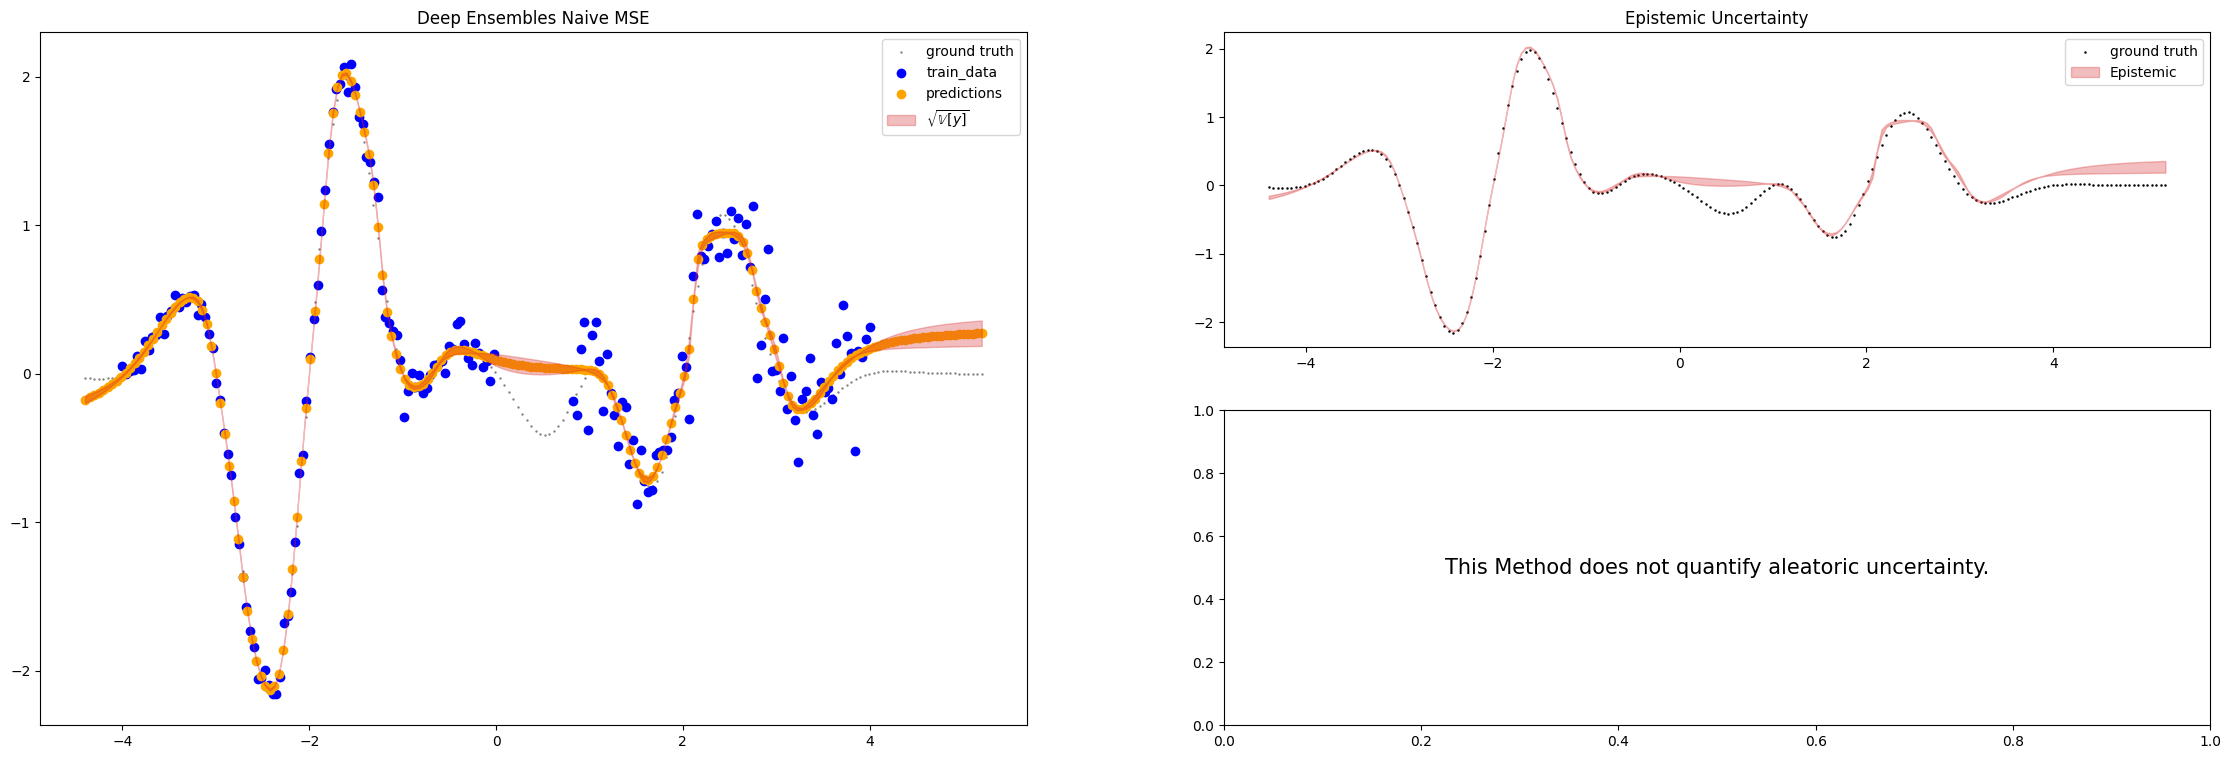

<Figure size 2800x900 with 0 Axes>

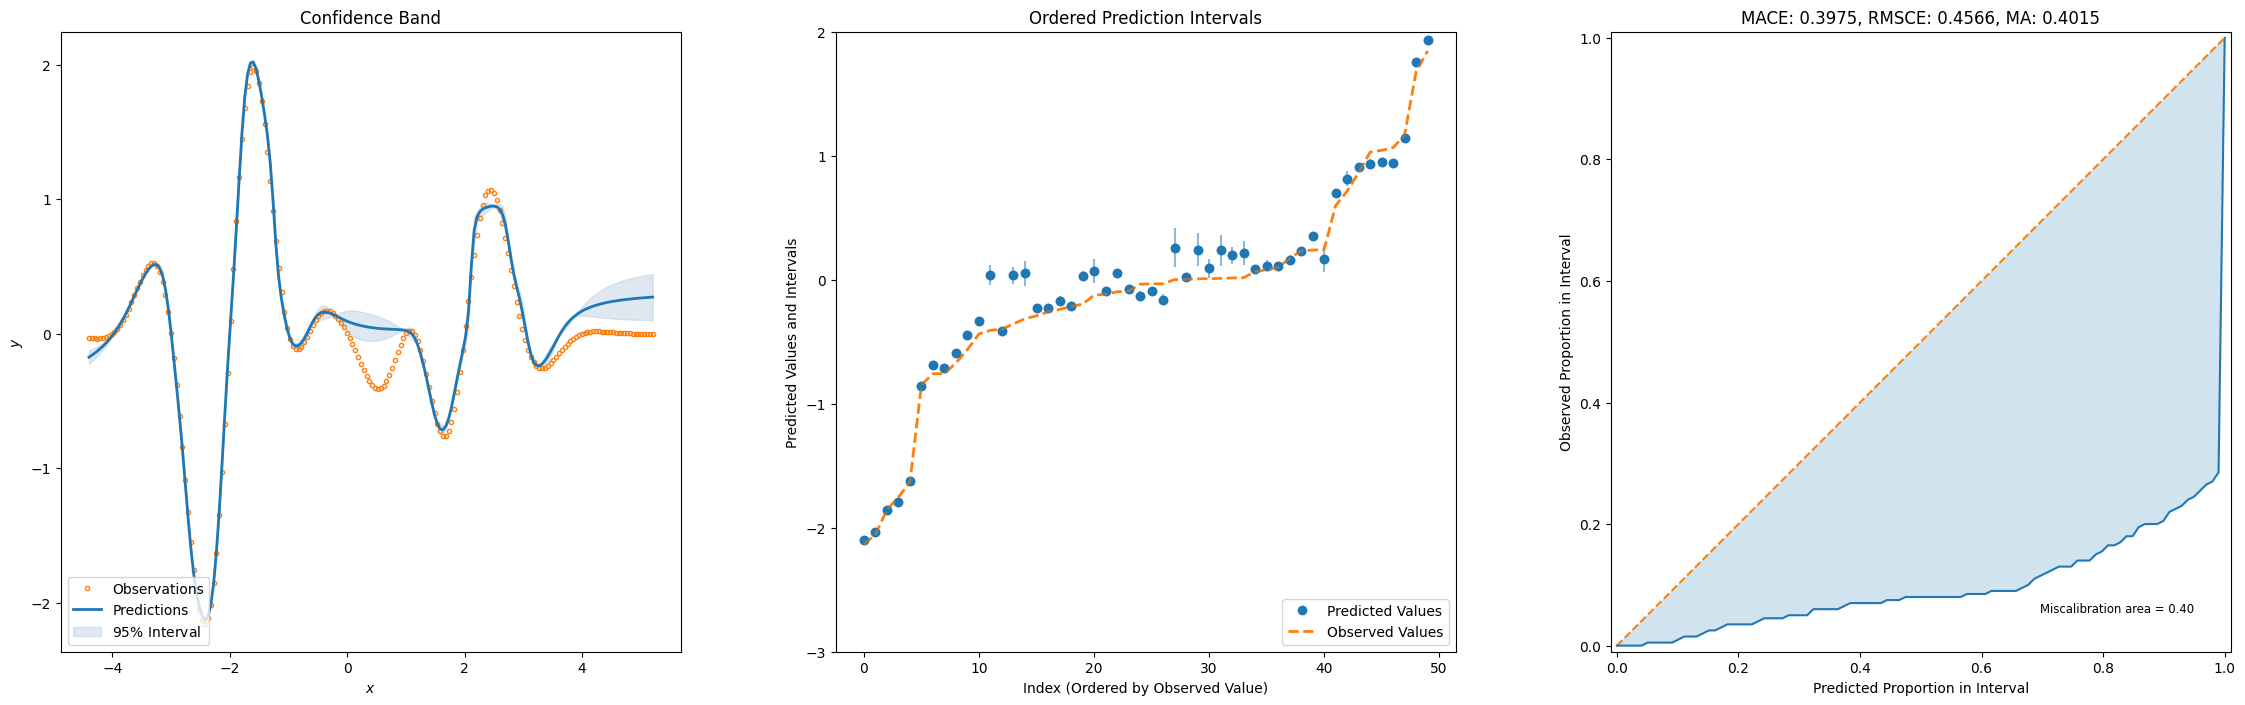

In [23]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    mse_de_mean,
    mse_de_std,
    epistemic=mse_de_std,
    title="Deep Ensembles Naive MSE",
)
plot_calibration_uq_toolbox(mse_de_mean, mse_de_std, y_test_cpu, X_test_cpu)

## NLL

In [24]:
n_ensembles = 5
trained_models = []
for i in range(n_ensembles):
    ensemble_member = BaseModel(
        base_config, MLP(n_outputs=2, n_hidden=[50, 50, 50], predict_sigma=True)
    )
    trained_models.append(
        basic_train_loop(ensemble_member, NLL(), train_loader, lr=1e-2, n_epochs=1500)
    )

/home/nils/.virtualenvs/uqboxEnv/lib/python3.9/site-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
100%|██████████| 1500/1500 [00:21<00:00, 70.80it/s, loss=-3.1292972564697266] 


In [27]:
# get predictions with ensemble wrapper
deep_ens_nll = DeepEnsembleModel(base_config, trained_models)
with torch.no_grad():
    out = deep_ens_nll.predict_step(X_test)
    nll_de_mean = out["mean"]
    nll_de_std = out["pred_uct"]
    nll_epistemic_de = out["epistemic_uct"]
    nll_aleatoric_de = out["aleatoric_uct"]

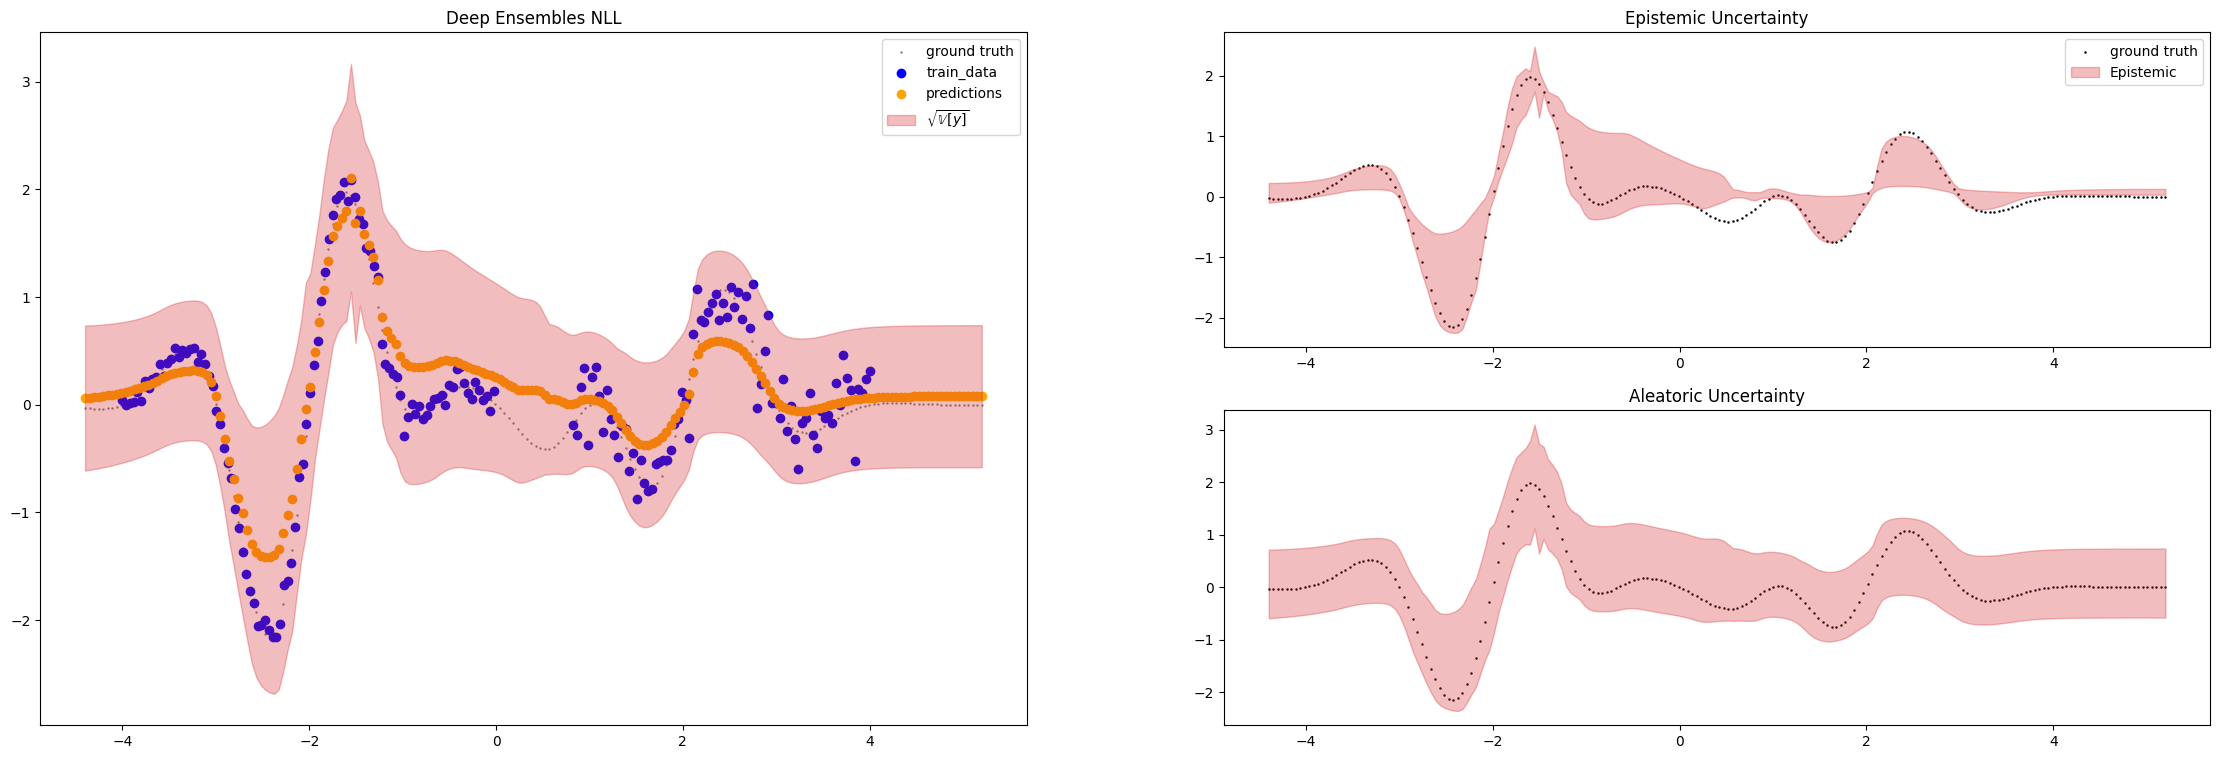

<Figure size 2800x900 with 0 Axes>

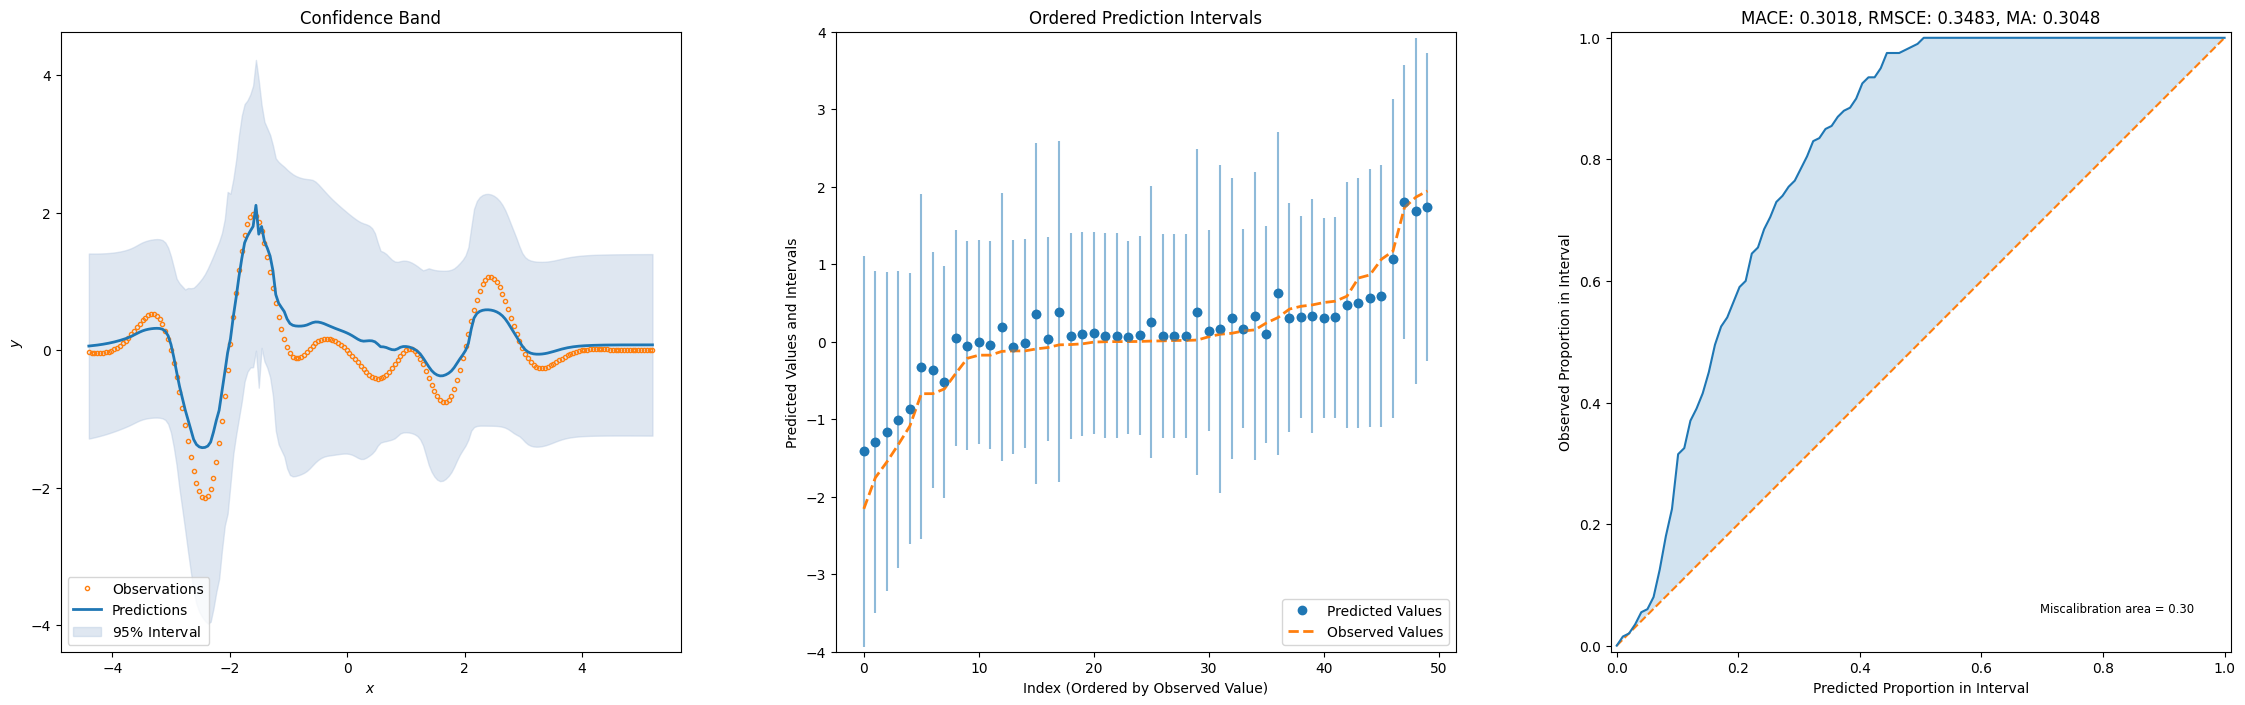

In [28]:
plot_predictions(
    X_train,
    y_train,
    X_test_cpu,
    y_test_cpu,
    nll_de_mean,
    nll_de_std,
    epistemic=nll_epistemic_de,
    aleatoric=nll_aleatoric_de,
    title="Deep Ensembles NLL",
)
plot_calibration_uq_toolbox(nll_de_mean, nll_de_std, y_test_cpu, X_test_cpu)